In [0]:
# LSTM networks are a type of RNN that uses special units in addition to standard units. 
# LSTM units include a 'memory cell' that can maintain information in memory for long periods of time.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 
# Part 1 - Data Preprocessing

In [0]:
# here take 2 years of data from company and predict next month of data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
dataset_train1=pd.read_csv("/content/drive/My Drive/Colab Notebooks/Stock Prediction using LSTM Recurrent Neural Network_googledta/trainset.csv")
dataset_train=dataset_train1.drop(["Adj Close"],axis=1)
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,3373900


In [12]:
# here we consider only open column to predict next month of data
training_set=dataset_train.iloc[:,1:2].values
training_set


array([[ 357.385559],
       [ 360.122742],
       [ 362.313507],
       ...,
       [1057.390015],
       [1051.599976],
       [1046.719971]])

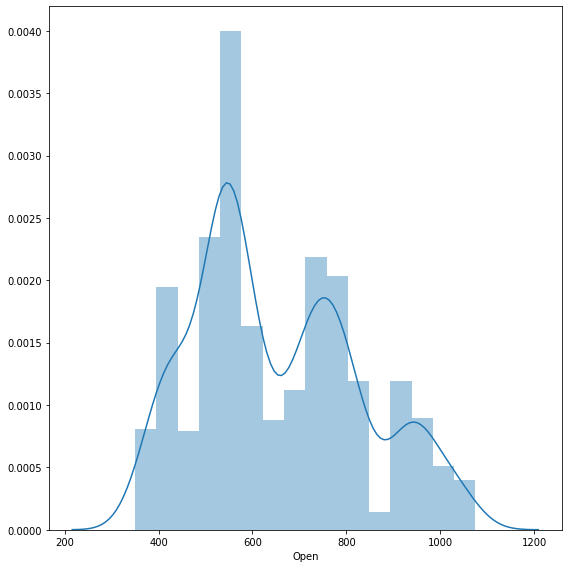

In [15]:
# If the distribution is not Gaussian or the standard deviation is very small, the min-max scaler works better.
import seaborn as sns
fig,ax1 = plt.subplots(1,1, figsize=(8,8))
sns.distplot(dataset_train["Open"],ax=ax1)
plt.tight_layout()

In [16]:
# feacture scaling = data scale between 0 to 1(all data in same scale)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(training_set)
training_set_scaled


array([[0.01011148],
       [0.01388614],
       [0.01690727],
       ...,
       [0.97543954],
       [0.9674549 ],
       [0.96072522]])

In [0]:
# Creating a data structure with 60 timesteps and 1 output
# rnn is works based on timesteps
# where outputs from previous time steps( ie, 60) are taken as inputs for the current time step 
# it should be 20,30,60 etc
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
X_train

array([[0.01011148, 0.01388614, 0.01690727, ..., 0.07456192, 0.0698898 ,
        0.068047  ],
       [0.01388614, 0.01690727, 0.02109298, ..., 0.0698898 , 0.068047  ,
        0.06189514],
       [0.01690727, 0.02109298, 0.02115463, ..., 0.068047  , 0.06189514,
        0.06842378],
       ...,
       [0.83010341, 0.84110805, 0.83286147, ..., 0.99528382, 0.98586493,
        0.9805695 ],
       [0.84110805, 0.83286147, 0.83699857, ..., 0.98586493, 0.9805695 ,
        0.97637719],
       [0.83286147, 0.83699857, 0.83491622, ..., 0.9805695 , 0.97637719,
        0.97543954]])

In [20]:
y_train

array([0.06189514, 0.06842378, 0.07453452, ..., 0.97637719, 0.97543954,
       0.9674549 ])

In [0]:
# Reshaping (rnn requires that below shape) ie (batch_size,timesteps,input_dim) 
# reshape into 3 dimensions
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
X_train

array([[[0.01011148],
        [0.01388614],
        [0.01690727],
        ...,
        [0.07456192],
        [0.0698898 ],
        [0.068047  ]],

       [[0.01388614],
        [0.01690727],
        [0.02109298],
        ...,
        [0.0698898 ],
        [0.068047  ],
        [0.06189514]],

       [[0.01690727],
        [0.02109298],
        [0.02115463],
        ...,
        [0.068047  ],
        [0.06189514],
        [0.06842378]],

       ...,

       [[0.83010341],
        [0.84110805],
        [0.83286147],
        ...,
        [0.99528382],
        [0.98586493],
        [0.9805695 ]],

       [[0.84110805],
        [0.83286147],
        [0.83699857],
        ...,
        [0.98586493],
        [0.9805695 ],
        [0.97637719]],

       [[0.83286147],
        [0.83699857],
        [0.83491622],
        ...,
        [0.9805695 ],
        [0.97637719],
        [0.97543954]]])

In [23]:
X_train.shape  # 3 dimensions

(1198, 60, 1)

In [0]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential # we use  Sequential
from keras.layers import Dense  # we use Dense layer to create a neuron, it is only output layer
from keras.layers import LSTM 
from keras.layers import Dropout # each and every epoch which and all neuron gives output as 0 that neurons are deactivated

In [26]:
# Initialising the RNN
regressor = Sequential()   # sequential layer



In [27]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 
# units means neurons




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [0]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [0]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))


In [0]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [32]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# loss is redusing

In [33]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





1198/1198 [==============================] - 18s 15ms/step - loss: 0.0410
Epoch 2/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0044
Epoch 3/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0039
Epoch 4/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0041
Epoch 5/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0042
Epoch 6/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0035
Epoch 7/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0035
Epoch 8/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0032
Epoch 9/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0031
Epoch 10/100
1198/1198 [==============================] - 12s 10ms/step - loss: 0.0031
Epoch 11/100
1198/1198 [=============

In [40]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Stock Prediction using LSTM Recurrent Neural Network_googledta/testset.csv')
dataset_test=dataset_test1.drop(["Adj Close"],axis=1)
dataset_test.head() # it is a real test data

,Date,Open,High,Low,Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1047600


In [41]:
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price

array([[1048.339966],
       [1064.310059],
       [1088.      ],
       [1094.      ],
       [1102.22998 ],
       [1109.400024],
       [1097.099976],
       [1106.300049],
       [1102.410034],
       [1132.51001 ],
       [1126.219971],
       [1131.410034],
       [1131.829956],
       [1137.48999 ],
       [1159.849976],
       [1177.329956],
       [1172.530029],
       [1175.079956],
       [1176.47998 ],
       [1167.829956],
       [1170.569946],
       [1162.609985],
       [1122.      ],
       [1090.599976],
       [1027.180054],
       [1081.540039],
       [1055.410034],
       [1017.25    ],
       [1048.      ],
       [1045.      ],
       [1048.949951],
       [1079.069946],
       [1088.410034],
       [1090.569946],
       [1106.469971],
       [1116.189941],
       [1112.640015],
       [1127.800049],
       [1141.23999 ],
       [1123.030029],
       [1107.869995],
       [1053.079956],
       [1075.140015],
       [1099.219971],
       [1089.189941],
       [11

In [0]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [44]:
predicted_stock_price # it is a predicted stock price data in month of jan 2017 ( only 1st 20 records )

array([[1042.146 ],
       [1040.7411],
       [1042.7185],
       [1050.521 ],
       [1061.5483],
       [1072.3916],
       [1080.9945],
       [1084.3186],
       [1084.6301],
       [1083.5249],
       [1086.8579],
       [1092.947 ],
       [1099.5751],
       [1104.7654],
       [1108.6163],
       [1114.4769],
       [1123.9191],
       [1133.1111],
       [1139.6298],
       [1143.1486]], dtype=float32)

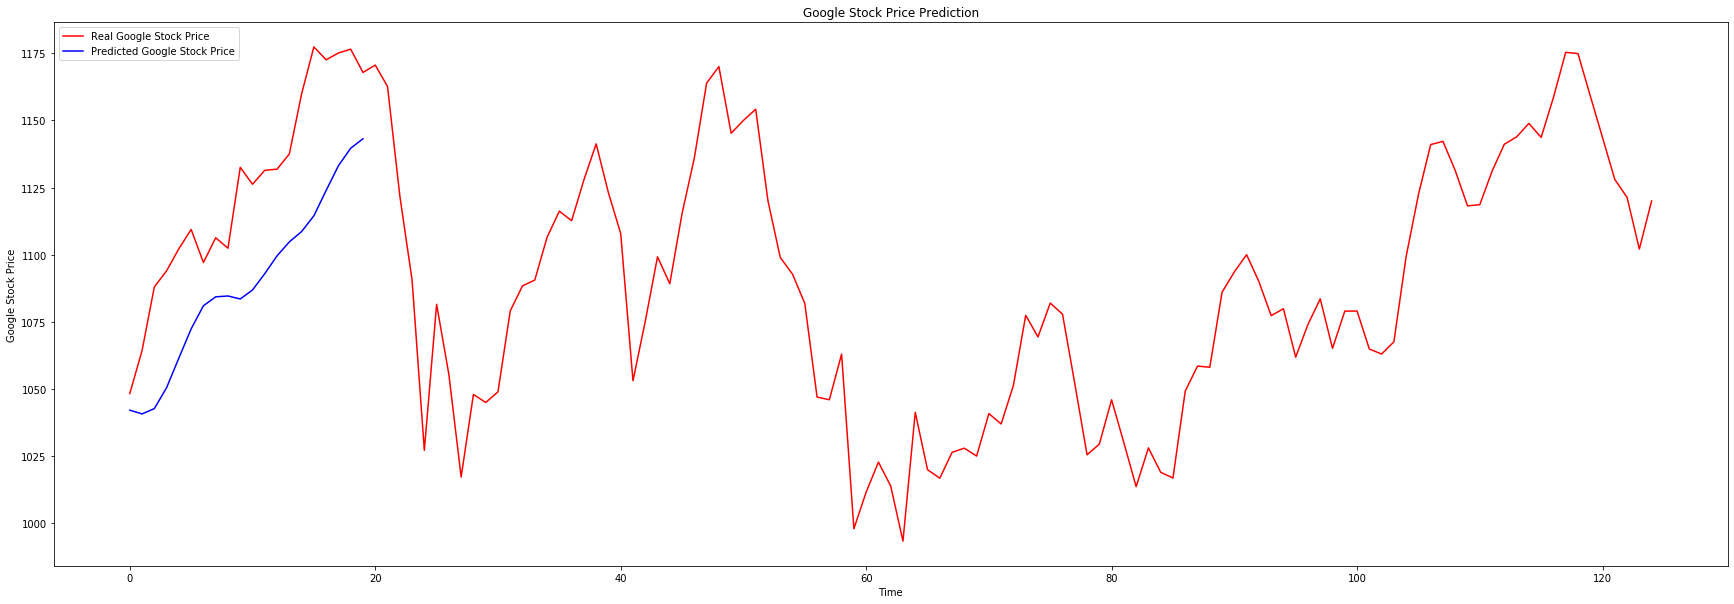

In [54]:
# Visualising the results
plt.figure(figsize=(30,10))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
